In [21]:
import os
import gzip
import numpy as np
from sklearn.linear_model import *
from sklearn.preprocessing import StandardScaler

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.externals import joblib

In [22]:
# data_dir="/Users/michellehu/git_dirs/ComplexSystems_AMATH563/data/"
wd="/mnt/Backups/jmhu"

data_dir=wd+"/git_dirs/ComplexSystems_AMATH563/data/"
model_dir=wd+"/git_dirs/ComplexSystems_AMATH563/models/"
fig_dir = wd+"/git_dirs/ComplexSystems_AMATH563/figures/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

if not os.path.exists(fig_dir):
    !mkdir $fig_dir

## Preprocessing and dataset exploration

In [131]:
# Download data if you haven't already
gz_fns=["t10k-labels-idx1-ubyte.gz", 
        "t10k-images-idx3-ubyte.gz", 
        "train-labels-idx1-ubyte.gz", 
        "train-images-idx3-ubyte.gz"]
data_paths=[data_dir + gz for gz in gz_fns]
data_sources=["http://yann.lecun.com/exdb/mnist/" + gz for gz in gz_fns]

for f, source in zip(data_paths, data_sources):
    if not os.path.exists(f):
        print("Missing", f)
        print("Downloading now...")
        !wget -O $f $source

check
check
check
check


In [116]:
# From https://github.com/daniel-e/mnist_octave/blob/master/mnist.py
def loadY(fnlabel):
    f = gzip.open(fnlabel, 'rb')
    f.read(8)
    return np.frombuffer(f.read(), dtype = np.uint8)

def loadX(fnimg):
    f = gzip.open(fnimg, 'rb')
    f.read(16)
    return np.frombuffer(f.read(), dtype = np.uint8).reshape((-1, 28*28))

# Unzip, reformat and reshape
trainX = loadX(data_dir+"train-images-idx3-ubyte.gz")
trainY = loadY(data_dir+"train-labels-idx1-ubyte.gz")
testX = loadX(data_dir+"t10k-images-idx3-ubyte.gz")
testY = loadY(data_dir+"t10k-labels-idx1-ubyte.gz")

In [25]:
# double check that these reshapings make sense
print(trainX[0].shape)
print(trainX[0].reshape(28,28).shape)
print("28*28 =", 28*28)

# Check sizes of train and test datasets and labels
print("train A:", trainX.shape)
print("train B:", trainY.shape)
print("test A:", testX.shape)
print("test B:", testY.shape)

# Look at class distribution
# http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/
print('labels: %s' % np.unique(trainY))
print('Class distribution: %s' % np.bincount(trainY))

(784,)
(28, 28)
28*28 = 784
train A: (60000, 784)
train B: (60000,)
test A: (10000, 784)
test B: (10000,)


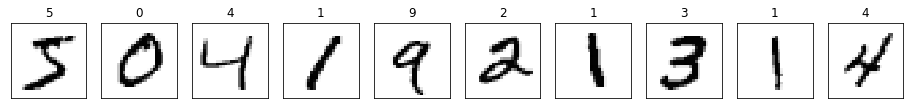

In [132]:
# Check out some digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = trainX[i].reshape((28,28))
    ax.imshow(img, cmap="Greys")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(trainY[i])

---

# Set up homework

In [28]:
# A is the vectorized MNIST training images
A=trainX.copy()
print(A.shape)

# B is the set of output vectors
B=trainY.copy()
print(B.shape)

(60000, 784)
(60000,)


In [29]:
# Normalize data
print(A.min(), A.max())
scaler = StandardScaler()
A = scaler.fit_transform(A)
testX = scaler.transform(testX)

B = np.array(B)
testY = np.array(testY)

print(A.min(), A.max())

0 255
-1.2742078920822268 244.94693302873063


### Question 1.

Using various AX=B solvers, determine a mapping from the image space (A) to the label space (B)

In [38]:
%%time
n_jobs=4

# Instantiate logistic regression models. Tolerance set to 0.01 from initial 0.0001, takes half the time
tol=0.01

# without regularization
saga=LogisticRegression(solver="saga", multi_class="multinomial", C=1, n_jobs=n_jobs, tol=tol)
saga_C01=LogisticRegression(solver="saga", multi_class="multinomial", C=0.1, n_jobs=n_jobs, tol=tol)
saga_C0005=LogisticRegression(solver="saga", multi_class="multinomial", C=0.005, n_jobs=n_jobs, tol=tol)

# with elasticnet regularization and saga solver
saga_elastic_L1_C01=LogisticRegression(solver="saga", multi_class="multinomial", C=0.1, penalty="elasticnet", l1_ratio=1, n_jobs=n_jobs, tol=tol)
saga_elastic_L2_C01=LogisticRegression(solver="saga", multi_class="multinomial", C=0.1, penalty="elasticnet", l1_ratio=0, n_jobs=n_jobs, tol=tol)
saga_elastic_mix_C01=LogisticRegression(solver="saga", multi_class="multinomial", C=0.1, penalty="elasticnet", l1_ratio=0.8, n_jobs=n_jobs, tol=tol)
saga_elastic_half_C01=LogisticRegression(solver="saga", multi_class="multinomial", C=0.1, penalty="elasticnet", l1_ratio=0.5, n_jobs=n_jobs, tol=tol)

# with elasticnet regularization and saga solver
saga_elastic_L1=LogisticRegression(solver="saga", multi_class="multinomial", C=0.01, penalty="elasticnet", l1_ratio=1, n_jobs=n_jobs, tol=tol)
saga_elastic_L2=LogisticRegression(solver="saga", multi_class="multinomial", C=0.01, penalty="elasticnet", l1_ratio=0, n_jobs=n_jobs, tol=tol)
saga_elastic_mix=LogisticRegression(solver="saga", multi_class="multinomial", C=0.01, penalty="elasticnet", l1_ratio=0.8, n_jobs=n_jobs, tol=tol)
saga_elastic_half=LogisticRegression(solver="saga", multi_class="multinomial", C=0.01, penalty="elasticnet", l1_ratio=0.5, n_jobs=n_jobs, tol=tol)

# with elasticnet regularization and saga solver
saga_elastic_L1_C0005=LogisticRegression(solver="saga", multi_class="multinomial", C=0.005, penalty="elasticnet", l1_ratio=1, n_jobs=n_jobs, tol=tol)
saga_elastic_L2_C0005=LogisticRegression(solver="saga", multi_class="multinomial", C=0.005, penalty="elasticnet", l1_ratio=0, n_jobs=n_jobs, tol=tol)
saga_elastic_mix_C0005=LogisticRegression(solver="saga", multi_class="multinomial", C=0.005, penalty="elasticnet", l1_ratio=0.8, n_jobs=n_jobs, tol=tol)
saga_elastic_half_C0005=LogisticRegression(solver="saga", multi_class="multinomial", C=0.005, penalty="elasticnet", l1_ratio=0.5, n_jobs=n_jobs, tol=tol)

# with stochastic average gradient
sgd_elastic_L2_C01=LogisticRegression(solver="sag", multi_class="multinomial", C=0.1, penalty="l2", n_jobs=n_jobs, tol=tol)
sgd_elastic_L2=LogisticRegression(solver="sag", multi_class="multinomial", C=0.01, penalty="l2", n_jobs=n_jobs, tol=tol)
sgd_elastic_L2_C0005=LogisticRegression(solver="sag", multi_class="multinomial", C=0.005, penalty="l2", n_jobs=n_jobs, tol=tol)

solvers = [saga,
           saga_elastic_L1, 
           saga_elastic_L2,
           saga_elastic_mix,
           saga_elastic_half,
           sgd_elastic_L2,
           saga_C01,
           saga_elastic_L1_C01,
           saga_elastic_L2_C01,
           saga_elastic_mix_C01,
           saga_elastic_half_C01,
           sgd_elastic_L2_C01,
           saga_C0005,
           saga_elastic_L1_C0005, 
           saga_elastic_L2_C0005,
           saga_elastic_mix_C0005,
           saga_elastic_half_C0005, 
           sgd_elastic_L2_C0005
          ]

solver_names = ["saga_mult",
           "saga_elastic_L1_mult", 
           "saga_elastic_L2_mult",
           "saga_elastic_mix_mult",
           "saga_elastic_half_mult",
           "sgd_elastic_L2_mult",
           "saga_C01_mult",
           "saga_elastic_L1_C01_mult", 
           "saga_elastic_L2_C01_mult",
           "saga_elastic_mix_C01_mult",
           "saga_elastic_half_C01_mult",
           "sgd_elastic_L2_C01_mult",
           "saga_C0005_mult",
           "saga_elastic_L1_C0005_mult", 
           "saga_elastic_L2_C0005_mult",
           "saga_elastic_mix_C0005_mult",
           "saga_elastic_half_C0005_mult",
           "sgd_elastic_L2_C0005_mult"
          ]

CPU times: user 143 µs, sys: 2 µs, total: 145 µs
Wall time: 151 µs


In [39]:
def optimize(model, x_train, y_train, x_test, y_test, cv=None):
    '''
    model = model instance to use with specified solver, regularization etc.
    x = samples, features; these are observations (images) with # samples = # measurements and features being the attributes of that measurement
    y = samples; these are the _labels_ for the observations of same size as samples
    '''
    model.fit(x_train, y_train)
    predictions=model.predict(x_test)
    score=model.score(x_test, y_test)
    
    if cv is not None:
        from sklearn.model_selection import cross_val_score
        # Run cv number of simulations using k-fold cross validation approach
        cv_scores=cross_val_score(model, x_train, y_train, cv=cv)
        return (model, predictions, score, cv_scores)    
    else:
        return (model, predictions, score)
    

def compute_loss(model, predictions, testX, testY):
    '''
    Assess model accuracy
    '''
    report=metrics.classification_report(testY, predictions)
    matrix=metrics.confusion_matrix(testY, predictions, normalize='true')
    return (report, matrix)

def plot_confusion(confusion_matrix, save_fn=None):
    '''
    Use seaborn to plot confusion matrix
    '''
    plt.figure(figsize=(6,6))
    sns.heatmap(confusion_matrix*100, annot=True, fmt=".1f", 
                linewidths=.5, 
                square = True, 
                robust = True,
                cmap = 'Blues', 
                cbar_kws={'label': 'Percent accuracy'}, 
               );

    plt.ylabel('True label');
    plt.xlabel('Predicted label');

    plt.xticks(weight="semibold");
    plt.yticks(rotation=0, weight="semibold");

    plt.tick_params(axis='both', which='both', length=0);

    title = str('Overall Accuracy: '+ "{0:.1f}".format(acc*100)+"%")
    plt.title(title, size = 15);

    if save_fn is not None:
        print("Saving as", save_fn)
        plt.savefig(save_fn, format='png', facecolor='white', edgecolor='none', dpi=300)
        
def plot_vip(trained_model):
    '''
    Check out very important pixels --> needs tweaking
    '''
    coef=trained_model.coef_
    coef=coef.reshape(10,28,28)
    cmin=coef.min()
    cmax=coef.max()

    fig, axes = plt.subplots(2, 5, sharex=True, sharey=True)

    for i, ax in enumerate(axes.flat):
        ax.set_axis_off()
        im = ax.imshow(coef[i], vmin=cmin, vmax=cmax)
        ax.set_title(i)

    cb_ax=fig.add_axes([0.92, 0.1, 0.03, 0.8])
    cbar=fig.colorbar(im, cax=cb_ax)

## Test times without cross-validation

saga_mult trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_mult.png
saga_elastic_L1_mult trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_L1_mult.png
saga_elastic_L2_mult trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_L2_mult.png
saga_elastic_mix_mult trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_mix_mult.png
saga_elastic_half_mult trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_half_mult.png
sgd_elastic_L2_mult trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_sgd_elastic_L2_mult.png
saga_C01_mult trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystem

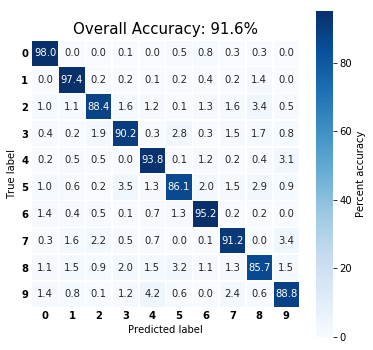

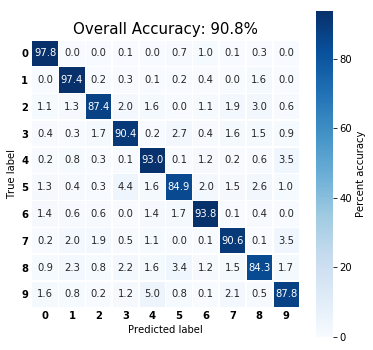

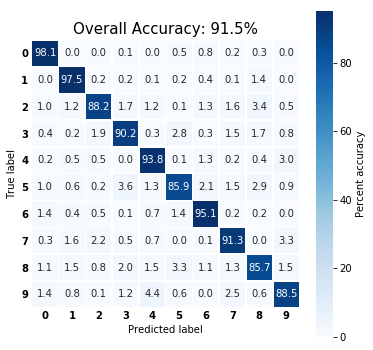

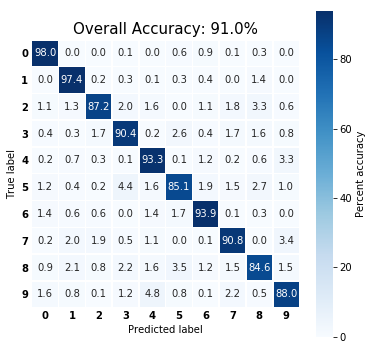

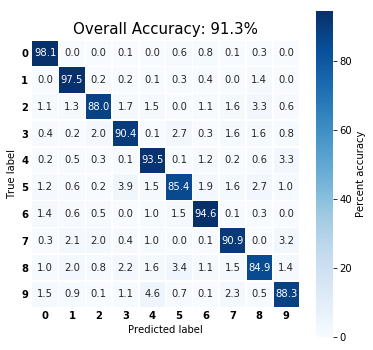

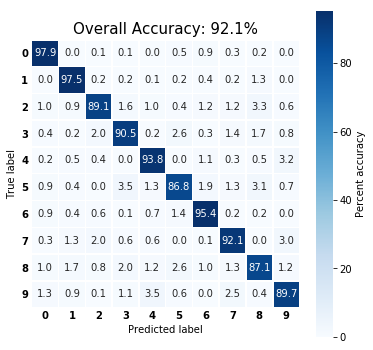

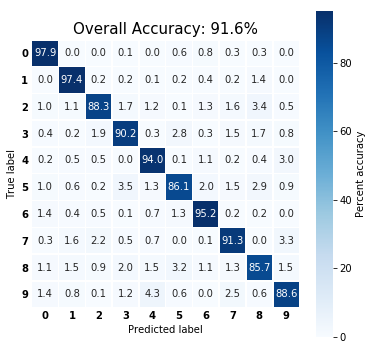

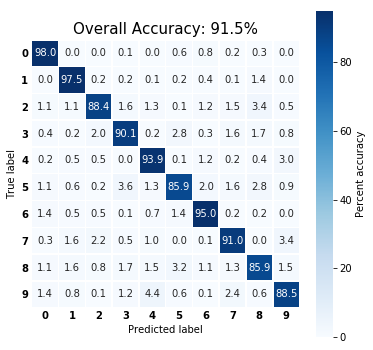

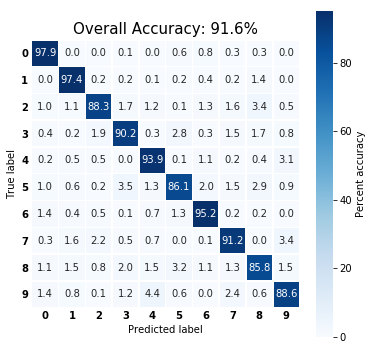

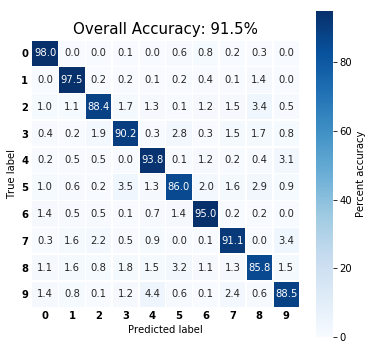

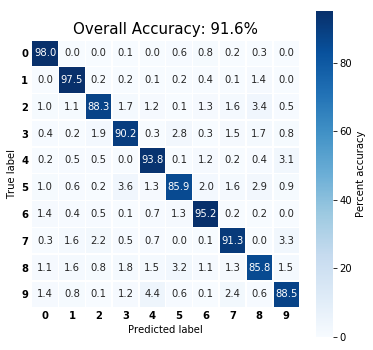

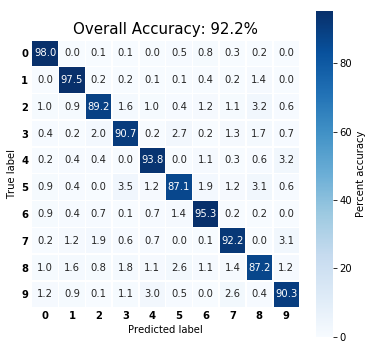

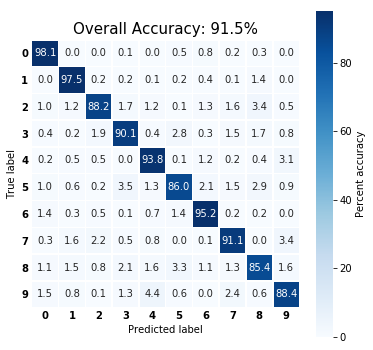

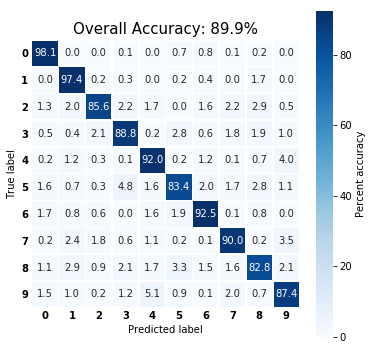

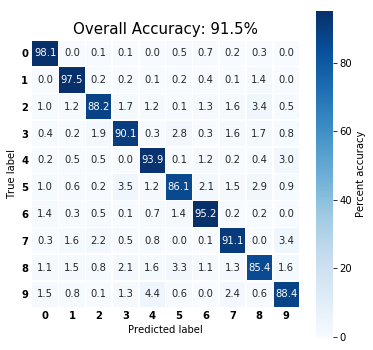

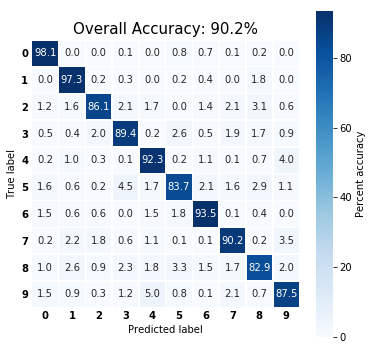

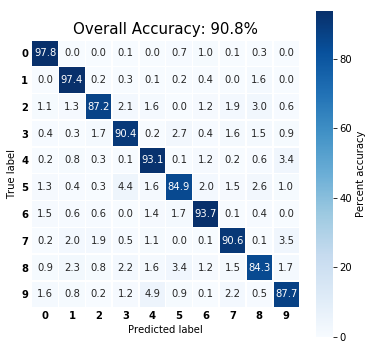

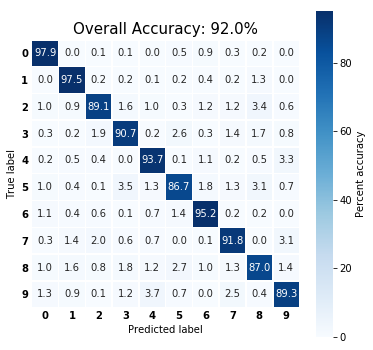

In [40]:
%%time
models=[]

# arrays will be arranged with different solutions in columns
preds=np.zeros((len(testX), len(solver_names)))
accs=np.zeros((len(solver_names)))

reports=[]
matrices=np.zeros((10, 10*len(solver_names)))


# Optimize, calculate losses and save confusion matrix
for i, (model, model_name) in enumerate(zip(solvers, solver_names)):
    
    model_fn=model_dir + model_name + ".pkl"
    
    if os.path.exists(model_fn):
        trained_model = joblib.load(model_fn)
        pred=trained_model.predict(testX)
        acc=trained_model.score(testX, testY)
        
        print("Model exists and loaded")
        
    else:
        trained_model, pred, acc = optimize(model, A, B, testX, testY)  
        
        print(model_name, "trained")
        
        joblib.dump(model, model_fn)

    models.append(trained_model)
    preds[:, i]=pred
    accs[i]=acc
    
    r, m = compute_loss(trained_model, pred, testX, testY)
    matrices[:, 10*i:10*i+10]=m
    reports.append(r)
    print("Losses computed")

    fig_name=fig_dir+"hw1_conf_matrix_"+model_name+".png"
    plot_confusion(m, save_fn=fig_name)

## with ovr

In [41]:
%%time
n_jobs=4

# Instantiate logistic regression models. Tolerance set to 0.01 from initial 0.0001, takes half the time
tol=0.01

# without regularization
saga=LogisticRegression(solver="saga", multi_class="ovr", C=1, n_jobs=n_jobs, tol=tol)
saga_C01=LogisticRegression(solver="saga", multi_class="ovr", C=0.1, n_jobs=n_jobs, tol=tol)

# with elasticnet regularization and saga solver
saga_elastic_L1_C01=LogisticRegression(solver="saga", multi_class="ovr", C=0.1, penalty="elasticnet", l1_ratio=1, n_jobs=n_jobs, tol=tol)
saga_elastic_L2_C01=LogisticRegression(solver="saga", multi_class="ovr", C=0.1, penalty="elasticnet", l1_ratio=0, n_jobs=n_jobs, tol=tol)
saga_elastic_mix_C01=LogisticRegression(solver="saga", multi_class="ovr", C=0.1, penalty="elasticnet", l1_ratio=0.8, n_jobs=n_jobs, tol=tol)
saga_elastic_half_C01=LogisticRegression(solver="saga", multi_class="ovr", C=0.1, penalty="elasticnet", l1_ratio=0.5, n_jobs=n_jobs, tol=tol)

# with elasticnet regularization and saga solver
saga_elastic_L1=LogisticRegression(solver="saga", multi_class="ovr", C=0.01, penalty="elasticnet", l1_ratio=1, n_jobs=n_jobs, tol=tol)
saga_elastic_L2=LogisticRegression(solver="saga", multi_class="ovr", C=0.01, penalty="elasticnet", l1_ratio=0, n_jobs=n_jobs, tol=tol)
saga_elastic_mix=LogisticRegression(solver="saga", multi_class="ovr", C=0.01, penalty="elasticnet", l1_ratio=0.8, n_jobs=n_jobs, tol=tol)
saga_elastic_half=LogisticRegression(solver="saga", multi_class="ovr", C=0.01, penalty="elasticnet", l1_ratio=0.5, n_jobs=n_jobs, tol=tol)

saga_elastic_L1_C0005=LogisticRegression(solver="saga", multi_class="ovr", C=0.005, penalty="elasticnet", l1_ratio=1, n_jobs=n_jobs, tol=tol)
saga_elastic_L2_C0005=LogisticRegression(solver="saga", multi_class="ovr", C=0.005, penalty="elasticnet", l1_ratio=0, n_jobs=n_jobs, tol=tol)
saga_elastic_mix_C0005=LogisticRegression(solver="saga", multi_class="ovr", C=0.005, penalty="elasticnet", l1_ratio=0.8, n_jobs=n_jobs, tol=tol)
saga_elastic_half_C0005=LogisticRegression(solver="saga", multi_class="ovr", C=0.005, penalty="elasticnet", l1_ratio=0.5, n_jobs=n_jobs, tol=tol)

# with stochastic average gradient
sgd_elastic_L2_C01=LogisticRegression(solver="sag", multi_class="ovr", C=0.1, penalty="l2", n_jobs=n_jobs, tol=tol)
sgd_elastic_L2=LogisticRegression(solver="sag", multi_class="ovr", C=0.01, penalty="l2", n_jobs=n_jobs, tol=tol)

solvers = [saga,
           saga_elastic_L1, 
           saga_elastic_L2,
           saga_elastic_mix,
           saga_elastic_half,
           sgd_elastic_L2,
           saga_C01,
           saga_elastic_L1_C01, 
           saga_elastic_L2_C01,
           saga_elastic_mix_C01,
           saga_elastic_half_C01,
           sgd_elastic_L2_C01,
           saga_C0005,
           saga_elastic_L1_C0005,
           saga_elastic_L2_C0005,
           saga_elastic_mix_C0005,
           saga_elastic_half_C0005,
           sgd_elastic_L2_C0005,
          ]

solver_names = ["saga_ovr",
           "saga_elastic_L1_ovr", 
           "saga_elastic_L2_ovr",
           "saga_elastic_mix_ovr",
           "saga_elastic_half_ovr",
           "sgd_elastic_L2_ovr",
           "saga_C01_ovr",
           "saga_elastic_L1_C01_ovr", 
           "saga_elastic_L2_C01_ovr",
           "saga_elastic_mix_C01_ovr",
           "saga_elastic_half_C01_ovr",
           "sgd_elastic_L2_C01_ovr",
                "saga_C0005_ovr",
           "saga_elastic_L1_C0005_ovr", 
           "saga_elastic_L2_C0005_ovr",
           "saga_elastic_mix_C0005_ovr",
           "saga_elastic_half_C0005_ovr",
           "sgd_elastic_L2_C0005_ovr"
          ]

CPU times: user 95 µs, sys: 1e+03 ns, total: 96 µs
Wall time: 34.8 µs


Model exists and loaded
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_ovr.png
saga_elastic_L1_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_L1_ovr.png
saga_elastic_L2_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_L2_ovr.png
saga_elastic_mix_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_mix_ovr.png
saga_elastic_half_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_half_ovr.png
sgd_elastic_L2_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_sgd_elastic_L2_ovr.png
saga_C01_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMAT

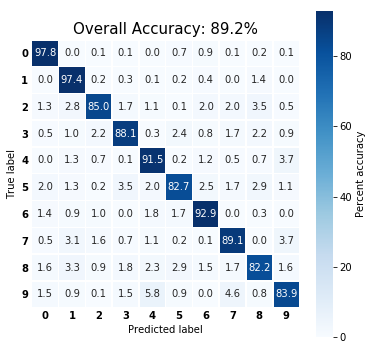

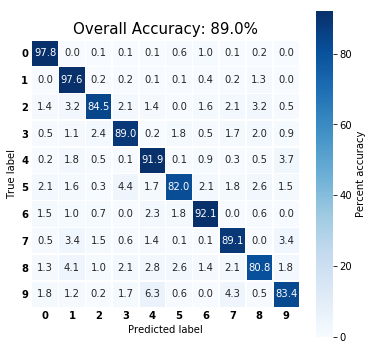

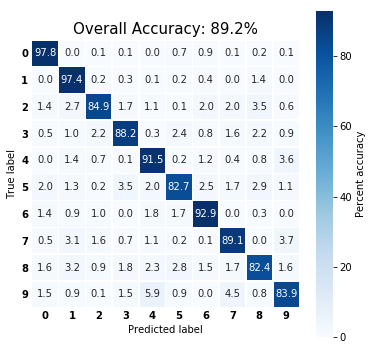

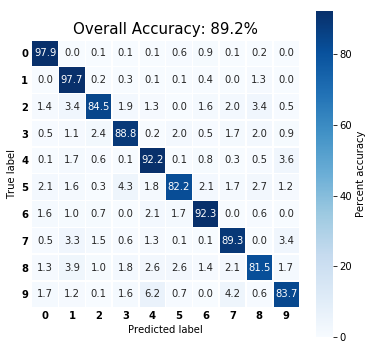

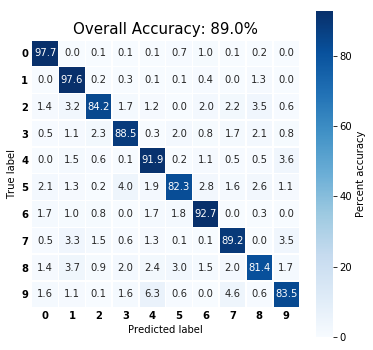

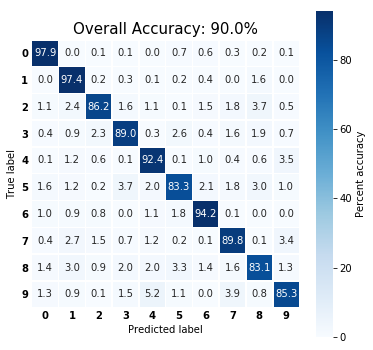

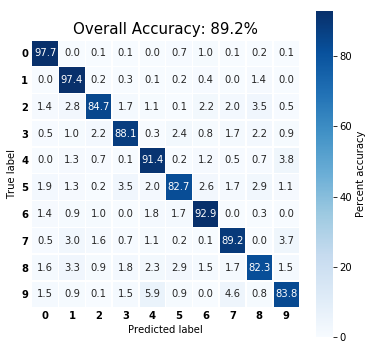

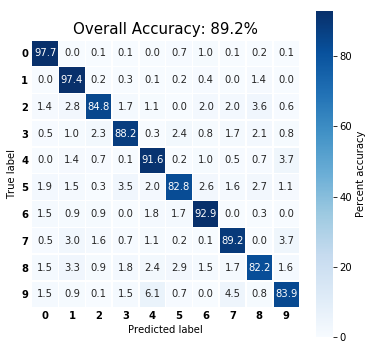

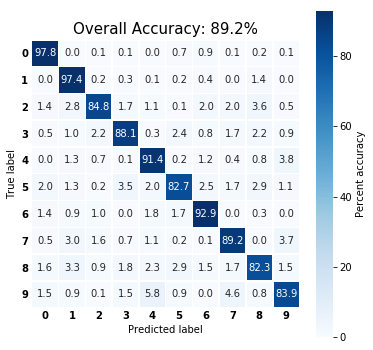

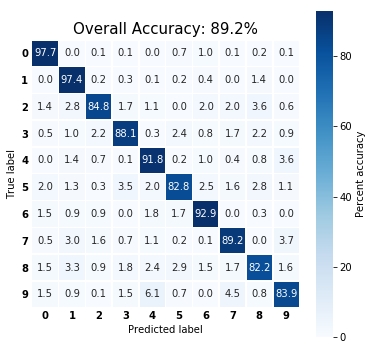

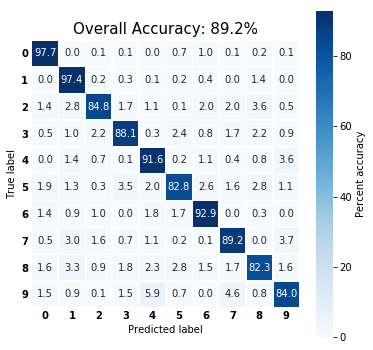

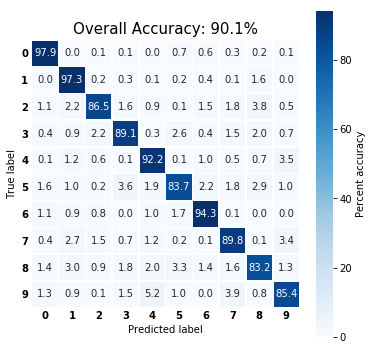

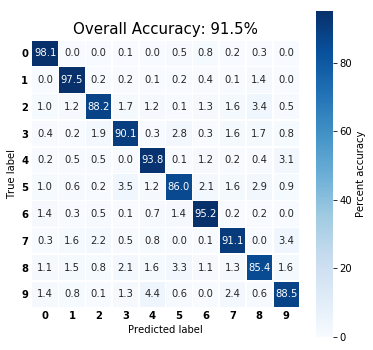

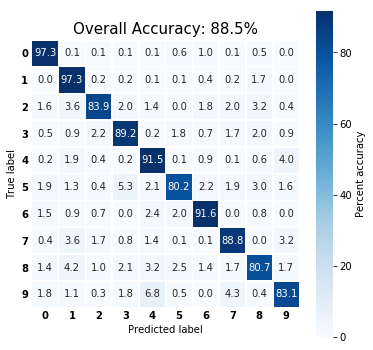

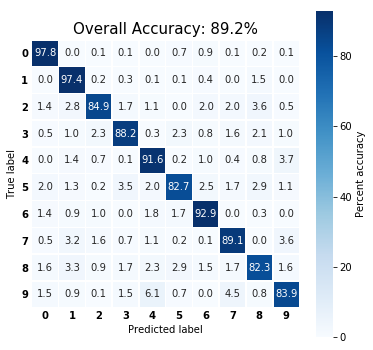

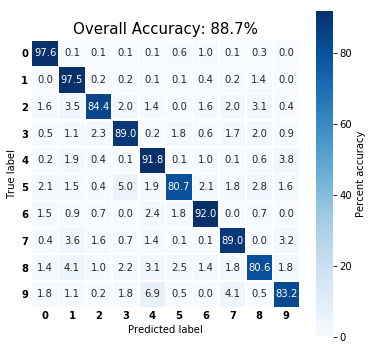

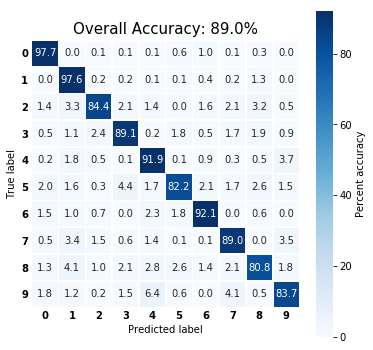

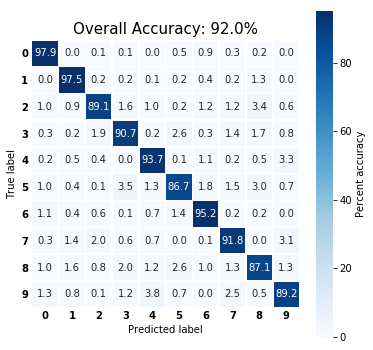

In [46]:
%%time
models=[]

# arrays will be arranged with different solutions in columns
preds=np.zeros((len(testX), len(solver_names)))
accs=np.zeros((len(solver_names)))

reports=[]
matrices=np.zeros((10, 10*len(solver_names)))


# Optimize, calculate losses and save confusion matrix
for i, (model, model_name) in enumerate(zip(solvers, solver_names)):
    
    model_fn=model_dir + model_name + ".pkl"
    
    if os.path.exists(model_fn):
        trained_model = joblib.load(model_fn)
        pred=trained_model.predict(testX)
        acc=trained_model.score(testX, testY)
        
        print("Model exists and loaded")
        
    else:
        trained_model, pred, acc = optimize(model, A, B, testX, testY)
        
        print(model_name, "trained")
        
        joblib.dump(model, model_fn)

    models.append(trained_model)
    preds[:, i]=pred
    accs[i]=acc
    
    r, m = compute_loss(trained_model, pred, testX, testY)
    matrices[:, 10*i:10*i+10]=m
    reports.append(r)
    print("Losses computed")

    fig_name=fig_dir+"hw1_conf_matrix_"+model_name+".png"
    plot_confusion(m, save_fn=fig_name)

In [47]:
# Pickle and save trained models
for model, model_name in zip(models, solver_names):    
    model_fn=model_dir + model_name + ".pkl"
    if not os.path.exists(model_fn):
        print(model_fn)
        joblib.dump(model, model_fn)

## Test times 5-fold cross-validation

saga_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_ovr_cv5.png
saga_elastic_L1_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_L1_ovr_cv5.png
saga_elastic_L2_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_L2_ovr_cv5.png
saga_elastic_mix_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_mix_ovr_cv5.png
saga_elastic_half_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_saga_elastic_half_ovr_cv5.png
sgd_elastic_L2_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/hw1_conf_matrix_sgd_elastic_L2_ovr_cv5.png
saga_C01_ovr trained
Losses computed
Saving as /mnt/Backups/jmhu/git_dirs/Co

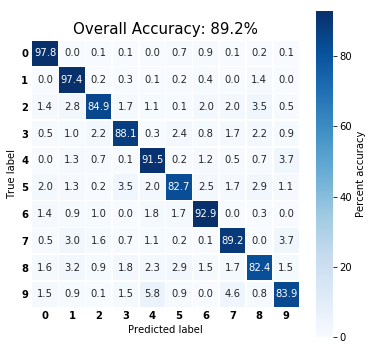

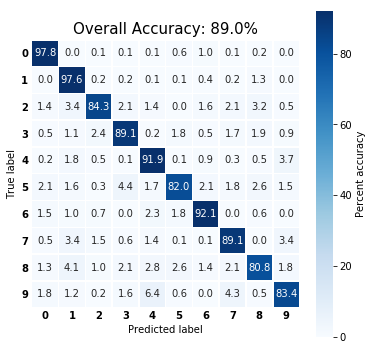

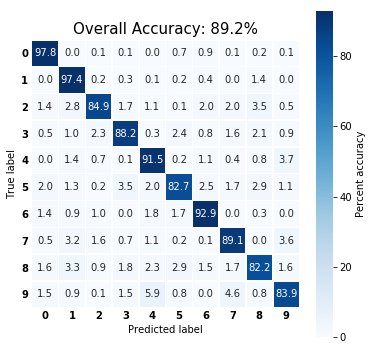

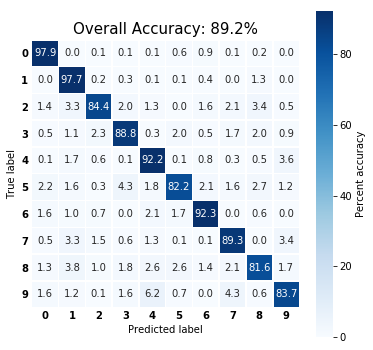

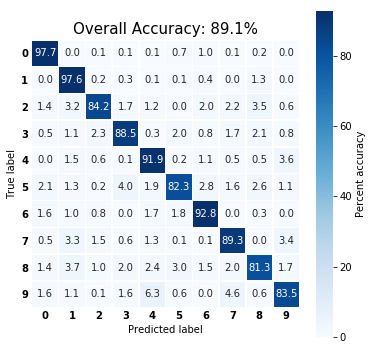

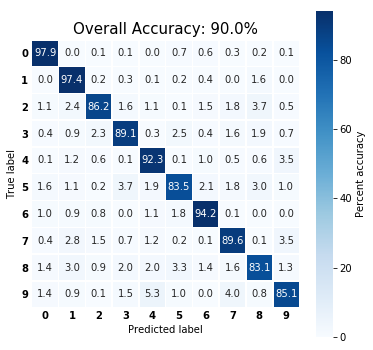

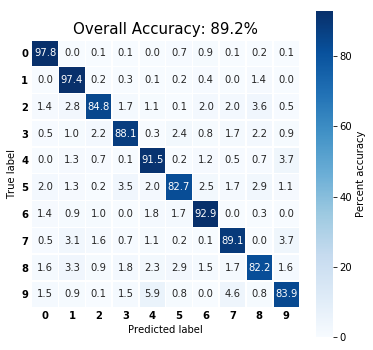

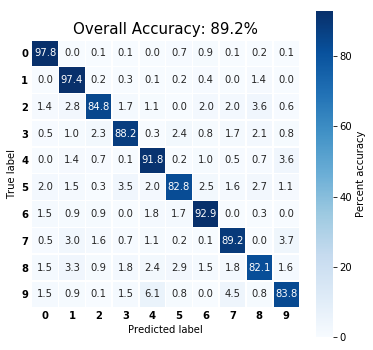

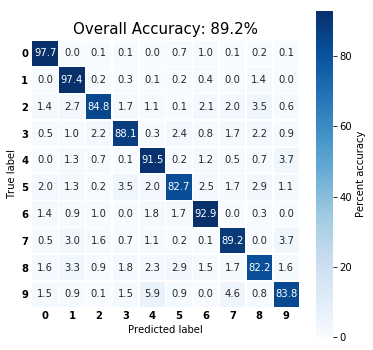

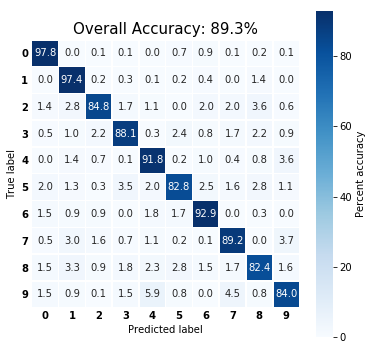

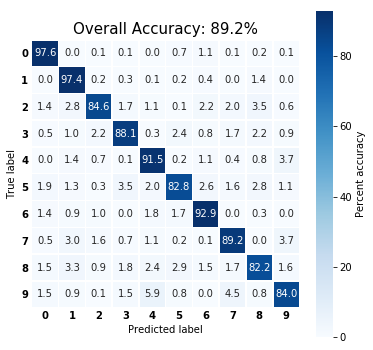

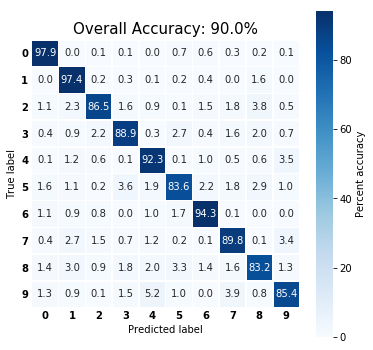

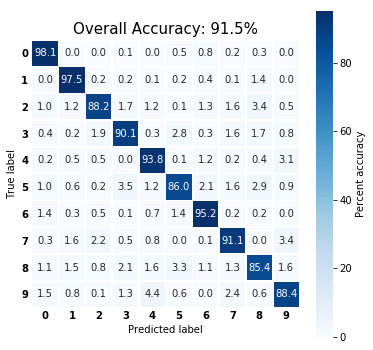

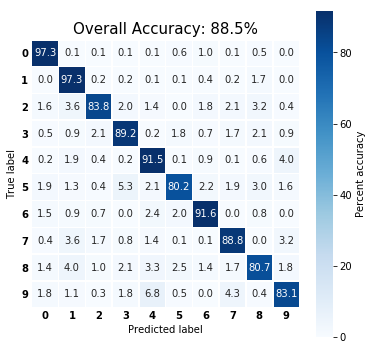

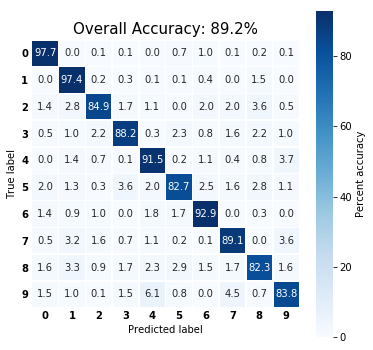

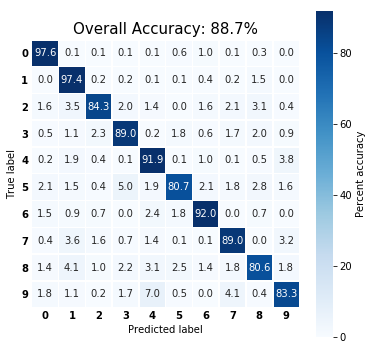

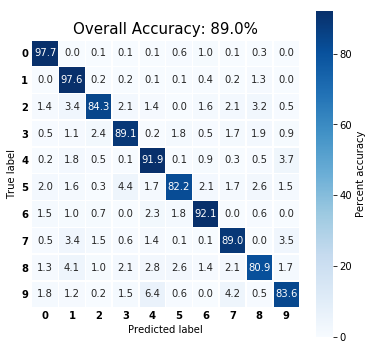

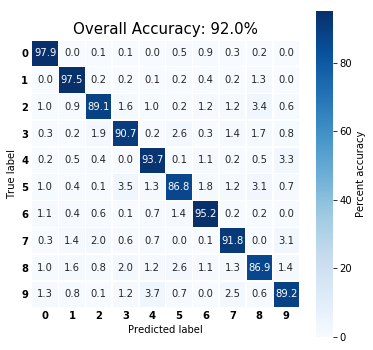

In [48]:
%%time
models_cv=[]

# arrays will be arranged with different solutions in columns
preds_cv=np.zeros((len(testX), len(solver_names)))
accs_cv=np.zeros((len(solver_names)))

cvs=[]
reports_cv=[]
matrices_cv=np.zeros((10, 10*len(solver_names)))


# Optimize, calculate losses and save confusion matrix
for i, (model, model_name) in enumerate(zip(solvers, solver_names)):
    
    model_fn=model_dir + model_name + "_cv5.pkl"
        
    if os.path.exists(model_fn):
        trained_model = joblib.load(model_fn)
        pred=trained_model.predict(testX)
        acc=trained_model.score(testX, testY)
        
        print("Model exists and loaded")
        
    else:
        trained_model, pred, acc, cv= optimize(model, A, B, testX, testY, cv=5)
        
        print(model_name, "trained")
        
        joblib.dump(model, model_fn)
        
    models_cv.append(trained_model)
    preds_cv[:, i]=pred
    accs_cv[i]=acc

    r, m = compute_loss(trained_model, pred, testX, testY)
    matrices_cv[:, 10*i:10*i+10]=m
    reports_cv.append(r)
    print("Losses computed")

    fig_name=fig_dir+"hw1_conf_matrix_"+model_name+"_cv5.png"
    plot_confusion(m, save_fn=fig_name)

### Question 2

Promote sparsity and rank which pixels are most informative for digit labelling

Use L1  
rank the 784 pixels to see which is most informative  
Most informative = largest coefficients in matrix X (trained_model.coef_) --> top 5% of pixels, visualized

### Question 3
Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible.

### Question 4
Redo the analysis with each digit individually to find the most important pixels for each digit.

# Individual digits

In [117]:
# Select training and test data by digit and relabel all test and training images that are not this digit to 0
for digit in range(10):
    print(digit)
    testY_digit=testY.copy()
    testY_digit[testY_digit != float(digit)] = 0
    
    testX_digit=testX.copy()
    
    trainY_digit=trainY.copy()
    trainY_digit[trainY_digit !=float(digit)] = 0
    
    trainX_digit=trainX.copy()

0
1
2
3
4
5
6
7
8
9


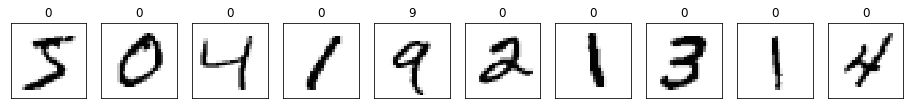

In [118]:
# Check out some digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = trainX_digit[i].reshape((28,28))
    ax.imshow(img, cmap="Greys")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(trainY_digit[i])

# Test run last digit (9)

## Run without normalization with decent mix - "elastic_mix_C01_mult"

In [119]:
xtrain = trainX_digit
ytrain = trainY_digit

xtest = testX_digit
ytest = testY_digit

In [127]:
# saga_elastic_mix_C0005_mult=LogisticRegression(solver="saga", multi_class="multinomial", C=0.005, penalty="elasticnet", l1_ratio=0.8, n_jobs=n_jobs, tol=tol)
saga_digit=LogisticRegression(solver="saga", multi_class="multinomial", C=0.1, 
                                               penalty="elasticnet", l1_ratio=0.8, n_jobs=n_jobs, tol=tol)


_test_9_noNorm_saga_elastic_mix_C0005_mult trained
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/_test_9_noNorm_saga_elastic_mix_C0005_multhw1_conf_matrix.png
CPU times: user 40 s, sys: 1.36 s, total: 41.4 s
Wall time: 39.1 s


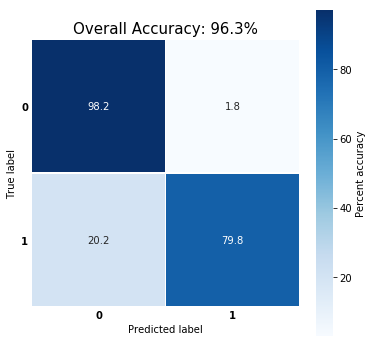

In [128]:
%%time

A=xtrain
B=ytrain
testX=xtest
testY=ytest
model=saga_digit

model_fn = model_dir + "test_9_noNorm_saga_elastic_mix_C01_mult.pkl"
model_name = "_test_9_noNorm_saga_elastic_mix_C01_mult"

trained_model, pred, acc = optimize(model, A, B, testX, testY)  
print(model_name, "trained")

joblib.dump(model, model_fn)

r, m = compute_loss(trained_model, pred, testX, testY)

fig_name=fig_dir+model_name+"hw1_conf_matrix.png"
# print(fig_name)
plot_confusion(m, save_fn=fig_name)

In [134]:
trained_model.coef_.shape

(1, 784)

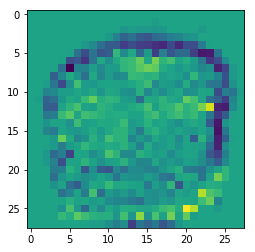

In [136]:
plt.imshow(trained_model.coef_.reshape(28,28))

## Run with normalization

In [137]:
print(trainX_digit.min(), trainX_digit.max())
scaler = StandardScaler()
trainX_digit = scaler.fit_transform(trainX_digit)
testX_digit = scaler.transform(testX_digit)

trainY_digit = np.array(trainY_digit)
testY_digit = np.array(testY_digit)

print(trainX_digit.min(), trainX_digit.max())

0 255
-1.2742078920822268 244.94693302873063


_test_9_Norm_saga_elastic_mix_C0005_mult trained
Saving as /mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/figures/_test_9_Norm_saga_elastic_mix_C0005_multhw1_conf_matrix.png
CPU times: user 30.7 s, sys: 1.13 s, total: 31.8 s
Wall time: 29.8 s


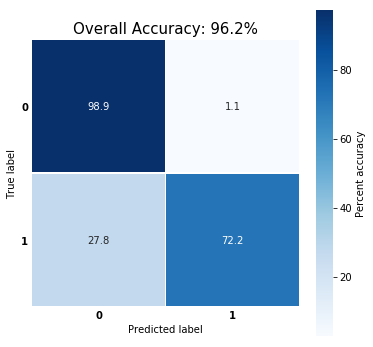

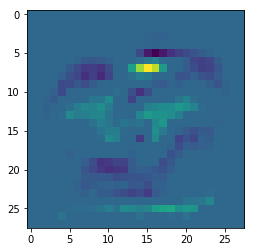

In [139]:
%%time

A=trainX_digit
B=trainY_digit
testX=testX_digit
testY=testY_digit
model=saga_digit

model_fn = model_dir + "test_9_Norm.pkl"
model_name = "_test_9_Norm_saga_elastic_mix_C0005_mult"

trained_model, pred, acc = optimize(model, A, B, testX, testY)  
print(model_name, "trained")

joblib.dump(model, model_fn)

r, m = compute_loss(trained_model, pred, testX, testY)

fig_name=fig_dir+model_name+"hw1_conf_matrix.png"
# print(fig_name)
plot_confusion(m, save_fn=fig_name)

plt.figure()

plt.imshow(trained_model.coef_.reshape(28,28))

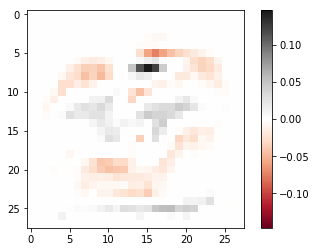

In [158]:
lim=max(np.abs(trained_model.coef_.min()), np.abs(trained_model.coef_.max()))

plt.imshow(trained_model.coef_.reshape(28,28), vmin=-lim, vmax=lim, cmap=plt.cm.RdGy)
plt.colorbar()

### Question 5
Think about the interpretation of what you are doing with this AX = B problem.


In [ ]:
f(x) = something
A = trainX (observations)
B = trainY (labels)

X = beta = loadings so we can transform (i.e. map) A (e.g. data, observations, images) into B (e.g. labels)
The way I've been doing this above has been using 10 different X's -- or a one vs. all approach 
see this https://towardsdatascience.com/kannada-visual-model-952cc6ec3a72 and this https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

Determine X using logistic regression specifying solvers, an error function, and regularization (constraints, penalties to tweak the function)
Use L1 norm where we minimize the average error (better performance with outliers than L2 norm)

Ranking most informative pixels

In [ ]:
# Convert labels to float type
train_labels = np.asfarray(trainY)
test_labels = np.asfarray(testY)


lr = np.arange(len(np.unique(test_labels)))

# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels.reshape(60000,1)).astype(np.float)
test_labels_one_hot = (lr==test_labels.reshape(10000,1)).astype(np.float)

# we don't want zeroes and ones in the labels:
train_labels_one_hot[train_labels_one_hot==0] = 0.01
train_labels_one_hot[train_labels_one_hot==1] = 0.99
test_labels_one_hot[test_labels_one_hot==0] = 0.01
test_labels_one_hot[test_labels_one_hot==1] = 0.99